<a href="https://colab.research.google.com/github/hyomin14/python_ML_practice/blob/main/04_Classification/Chapter4_practice_santander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **분류 실습 - 캐글 산탄데르 고객 만족 예측**

370개의 피처로 주어진 데이터 세트 기반에서 고객 만족 여부 예측

클래스 레이블 명은 TARGET, 이 값이 1이면 불만족, 0이면 만족

대부분이 만족이고 불만족은 일부여서 모델 성능 평가는 ROC-AUC로 평가

### **데이터 전처리**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv("train_santander.csv", encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head()

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,300.0,122.22,300.0,240.75,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3.00,2.07,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,195.0,195.0,0.0,0.0,195.0,0.0,0.0,195.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,91.56,138.84,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,...,40501.08,13501.47,0.0,0.0,0.0,0.0,0.0,0.0,85501.89,85501.89,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [ ]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [ ]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt = cust_df['TARGET'].count()
print('unsatisfied의 비율은 {0:.2f}'.format(unsatisfied_cnt/total_cnt))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied의 비율은 0.04


In [ ]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.0,76020.0,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.0,76020.000000,76020.000000,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,3.160715,68.803937,113.056934,68.205140,113.225058,137.242763,68.618087,113.792410,140.403479,5.477676,0.011458,0.003762,0.0,0.0,0.958024,0.663760,0.000105,0.000026,0.032833,0.028598,0.067522,0.045462,0.052249,0.042936,0.041476,0.010168,0.009997,0.000026,0.000026,0.050855,...,1077.256756,1048.856447,68.275452,9.505287,124.620962,110.026575,3.997023e+03,613.534443,5.703008e+03,4.401002e+03,3639.419939,556.184178,4852.261814,3857.848542,771.227449,162.170439,9.569502e+02,7.509563e+02,0.175324,0.0,0.513023,0.344174,9.117181e+01,3.646318e+01,1.310316e+02,1.092169e+02,0.213071,0.001910,0.253907,0.186630,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,95.268204,319.605516,512.154823,531.897917,950.086398,697.712596,535.473750,953.578624,712.767240,465.391149,0.106425,0.061221,0.0,0.0,0.200535,0.472425,0.010258,0.005129,0.178202,0.166674,0.250925,0.208316,0.222531,0.202714,0.199390,0.100325,0.099486,0.005129,0.005129,0.219703,...,9614.906985,8189.948852,1733.838226,519.389157,2205.249804,1935.305713,3.777314e+04,9292.752726,4.620254e+04,3.550718e+04,26359.174223,7182

In [ ]:
#var3 칼럼은 min 값이 -999999 -> NaN이나 특정 예외 값을 -999999로 변환했을 것임
cust_df['var3'].value_counts()

 2         74165
 8           138
-999999      116
 9           110
 3           108
           ...  
 177           1
 87            1
 151           1
 215           1
 191           1
Name: var3, Length: 208, dtype: int64

In [ ]:
#var3의 -999999를 가장 값이 많은 2로 변환
cust_df['var3'].replace(-999999, 2, inplace=True)
#ID 피처는 단순 식별자이므로 drop 
cust_df.drop('ID', axis=1, inplace=True)

#피처 세트와 레이블 세트 분리, 레이블 칼럼은 DataFrame의 맨마지막에 위치해 칼럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:', X_features.shape)

피처 데이터 shape: (76020, 369)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=0)

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 데이터 세트 shape: {0}, 테스트 데이터 세트 shape: {1}'.format(X_train.shape, X_test.shape))

print('학습 데이터 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print()
print('테스트 데이터 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 데이터 세트 shape: (60816, 369), 테스트 데이터 세트 shape: (15204, 369)
학습 데이터 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

테스트 데이터 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


학습과 테스트 데이터 세트 모두 TARGET 값의 분포가 원본과 비슷하게 전체 데이터의 4% 정도만 불만족 값

### **XGBoost 모델 학습과 하이퍼 파라미터 튜닝**

In [ ]:
#사이킷런 래퍼인 XGBClassifier기반으로 학습 수행
#테스트 데이터 세트를 XGBoost의 평가 데이터 세트로 사용하면 과적합의 가능성을 증가시킬 수 있음, 실제로는 이렇게 X
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

#n_estimators는 500으로 random_state는 예제 수행 시마다 동일 예측 결과를 위해 설정
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

#성능 평가 지표를 auc로, 조기 중단 파라미터는 100ㅇ로 설정하고 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])
xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.799928	validation_1-auc:0.803548
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.802222	validation_1-auc:0.805222
[2]	validation_0-auc:0.80819	validation_1-auc:0.813162
[3]	validation_0-auc:0.8127	validation_1-auc:0.813243
[4]	validation_0-auc:0.81648	validation_1-auc:0.816979
[5]	validation_0-auc:0.816018	validation_1-auc:0.816629
[6]	validation_0-auc:0.816474	validation_1-auc:0.817776
[7]	validation_0-auc:0.818148	validation_1-auc:0.818464
[8]	validation_0-auc:0.81806	validation_1-auc:0.818295
[9]	validation_0-auc:0.817039	validation_1-auc:0.818087
[10]	validation_0-auc:0.818318	validation_1-auc:0.818749
[11]	validation_0-auc:0.818711	validation_1-auc:0.818521
[12]	validation_0-auc:0.818673	validation_1-auc:0.818516
[13]	validation_0-auc:0.819156	validation_1-auc:0.818998
[14]	validation_0-auc:0.819847	validation_1-auc:0.81999
[15

In [ ]:
#하이퍼 파라미터 튜닝
#일차 튜닝 대상 : max_depth, min_child_weight, colsample_bytree

from sklearn.model_selection import GridSearchCV

#하이퍼 파라미터 테스트의 수행 속도 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100)
params={'max_depth' : [5, 7], 'min_child_weight' : [1, 3], 'colsample_bytree' : [0.5, 0.75]}

#cv는 3으로 지정
gridcv = GridSearchCV(xgb_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average="macro")
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[22]	validation_0-auc:0.84676	validation_1-auc:0.838167
[23]	validation_0-auc:0.848966	validation_1-auc:0.83963
[24]	validation_0-auc:0.850153	validation_1-auc:0.840161
[25]	validation_0-auc:0.850518	validation_1-auc:0.838865
[26]	validation_0-auc:0.850326	validation_1-auc:0.83861
[27]	validation_0-auc:0.851898	validation_1-auc:0.839714
[28]	validation_0-auc:0.853439	validation_1-auc:0.83974
[29]	validation_0-auc:0.853446	validation_1-auc:0.840649
[30]	validation_0-auc:0.854315	validation_1-auc:0.840818
[31]	validation_0-auc:0.855389	validation_1-auc:0.841412
[32]	validation_0-auc:0.855959	validation_1-auc:0.841502
[33]	validation_0-auc:0.856346	validation_1-auc:0.841478
[34]	validation_0-auc:0.856286	validation_1-auc:0.841234
[35]	validation_0-auc:0.857969	validation_1-auc:0.842276
[36]	validation_0-auc:0.859291	validation_1-auc:0.842627
[37]	validation_0-auc:0.859418	validation_1-auc:0.84241
[38]	validation_0-auc:0.860148	validation_1-auc:0.842336
[39]	validation_0-auc:0.860092	valid

In [ ]:
#GridSearchCV로 구한 최적 파라미터 + n_estimators는 1000으로 증가시키고, learning_rate=0.02로 감소, reg_alpha=0.03추가
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.02, max_depth=5, min_child_weight=1, colsample_bytree=0.5, reg_alpha=0.03)

#성능 평가 지표를 auc로, 조기 중단 파라미터 값은 200으로 설정하고 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds=200, eval_metric='auc', eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.817665	validation_1-auc:0.814986
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.81987	validation_1-auc:0.814699
[2]	validation_0-auc:0.818798	validation_1-auc:0.813863
[3]	validation_0-auc:0.821696	validation_1-auc:0.815841
[4]	validation_0-auc:0.827716	validation_1-auc:0.822558
[5]	validation_0-auc:0.822253	validation_1-auc:0.818887
[6]	validation_0-auc:0.825218	validation_1-auc:0.818733
[7]	validation_0-auc:0.826898	validation_1-auc:0.820357
[8]	validation_0-auc:0.832836	validation_1-auc:0.827253
[9]	validation_0-auc:0.833574	validation_1-auc:0.827534
[10]	validation_0-auc:0.832205	validation_1-auc:0.825896
[11]	validation_0-auc:0.829664	validation_1-auc:0.824911
[12]	validation_0-auc:0.828593	validation_1-auc:0.824409
[13]	validation_0-auc:0.829674	validation_1-auc:0.824657
[14]	validation_0-auc:0.833554	validation_1-auc:0.82782

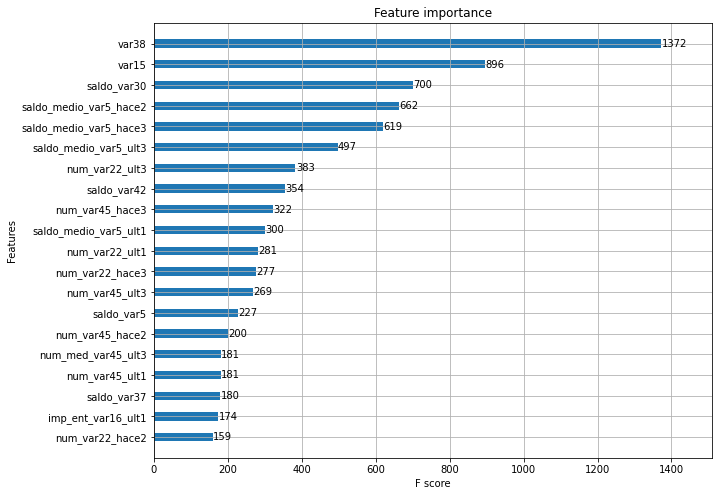

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

### **LightGBM 모델 학습과 하이퍼파라미터 튜닝**

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

evals=[(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=evals, verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.817384	valid_0's binary_logloss: 0.165046
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.81863	valid_0's binary_logloss: 0.16
[3]	valid_0's auc: 0.827411	valid_0's binary_logloss: 0.156287
[4]	valid_0's auc: 0.832175	valid_0's binary_logloss: 0.153416
[5]	valid_0's auc: 0.83481	valid_0's binary_logloss: 0.151206
[6]	valid_0's auc: 0.834721	valid_0's binary_logloss: 0.149303
[7]	valid_0's auc: 0.83659	valid_0's binary_logloss: 0.147804
[8]	valid_0's auc: 0.837602	valid_0's binary_logloss: 0.146466
[9]	valid_0's auc: 0.838114	valid_0's binary_logloss: 0.145476
[10]	valid_0's auc: 0.838472	valid_0's binary_logloss: 0.144681
[11]	valid_0's auc: 0.83808	valid_0's binary_logloss: 0.143978
[12]	valid_0's auc: 0.837771	valid_0's binary_logloss: 0.14341
[13]	valid_0's auc: 0.838063	valid_0's binary_logloss: 0.142835
[14]	valid_0's auc: 0.838485	valid_0's binary_logloss: 0.142296
[15]	valid_0's auc: 0.838542	valid_0's binary_logloss: 0.14

In [ ]:
from sklearn.model_selection import GridSearchCV

#하이퍼 파라미터 테스트의 수행 속도 향상시키기 위해 n_estimators=200으로 감소
lgbm_clf = LGBMClassifier(n_estimators=200)

params={'num_leaves' : [32, 64], 'max_depth' : [128, 160], 'min_child_samples' : [60, 100], 'subsample' : [0.8, 1]}
gridcv = GridSearchCV(lgbm_clf, param_grid=params)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average="macro")
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.823664	valid_0's binary_logloss: 0.156198	valid_1's auc: 0.821078	valid_1's binary_logloss: 0.16488
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.82965	valid_0's binary_logloss: 0.15092	valid_1's auc: 0.824865	valid_1's binary_logloss: 0.15978
[3]	valid_0's auc: 0.835112	valid_0's binary_logloss: 0.147151	valid_1's auc: 0.826157	valid_1's binary_logloss: 0.156174
[4]	valid_0's auc: 0.839678	valid_0's binary_logloss: 0.14422	valid_1's auc: 0.830489	valid_1's binary_logloss: 0.153395
[5]	valid_0's auc: 0.842477	valid_0's binary_logloss: 0.141762	valid_1's auc: 0.832915	valid_1's binary_logloss: 0.151083
[6]	valid_0's auc: 0.845763	valid_0's binary_logloss: 0.139668	valid_1's auc: 0.835313	valid_1's binary_logloss: 0.149317
[7]	valid_0's auc: 0.846352	valid_0's binary_logloss: 0.137997	valid_1's auc: 0.835977	valid_1's binary_logloss: 0.14773
[8]	valid_0's auc: 0.849153	valid_0's binary_logloss: 0.13653	valid_1's auc: 0.837152	vali

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, subsample=0.8, min_child_samples=100, max_depth=128)

evals=[(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=evals, verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.821775	valid_0's binary_logloss: 0.164676
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.829264	valid_0's binary_logloss: 0.159437
[3]	valid_0's auc: 0.83245	valid_0's binary_logloss: 0.155746
[4]	valid_0's auc: 0.836758	valid_0's binary_logloss: 0.152668
[5]	valid_0's auc: 0.837959	valid_0's binary_logloss: 0.150325
[6]	valid_0's auc: 0.839878	valid_0's binary_logloss: 0.148379
[7]	valid_0's auc: 0.840649	valid_0's binary_logloss: 0.146892
[8]	valid_0's auc: 0.840889	valid_0's binary_logloss: 0.145589
[9]	valid_0's auc: 0.840982	valid_0's binary_logloss: 0.144614
[10]	valid_0's auc: 0.841093	valid_0's binary_logloss: 0.143703
[11]	valid_0's auc: 0.841325	valid_0's binary_logloss: 0.142968
[12]	valid_0's auc: 0.841299	valid_0's binary_logloss: 0.142326
[13]	valid_0's auc: 0.841979	valid_0's binary_logloss: 0.141731
[14]	valid_0's auc: 0.842271	valid_0's binary_logloss: 0.141213
[15]	valid_0's auc: 0.841797	valid_0's binary_loglo